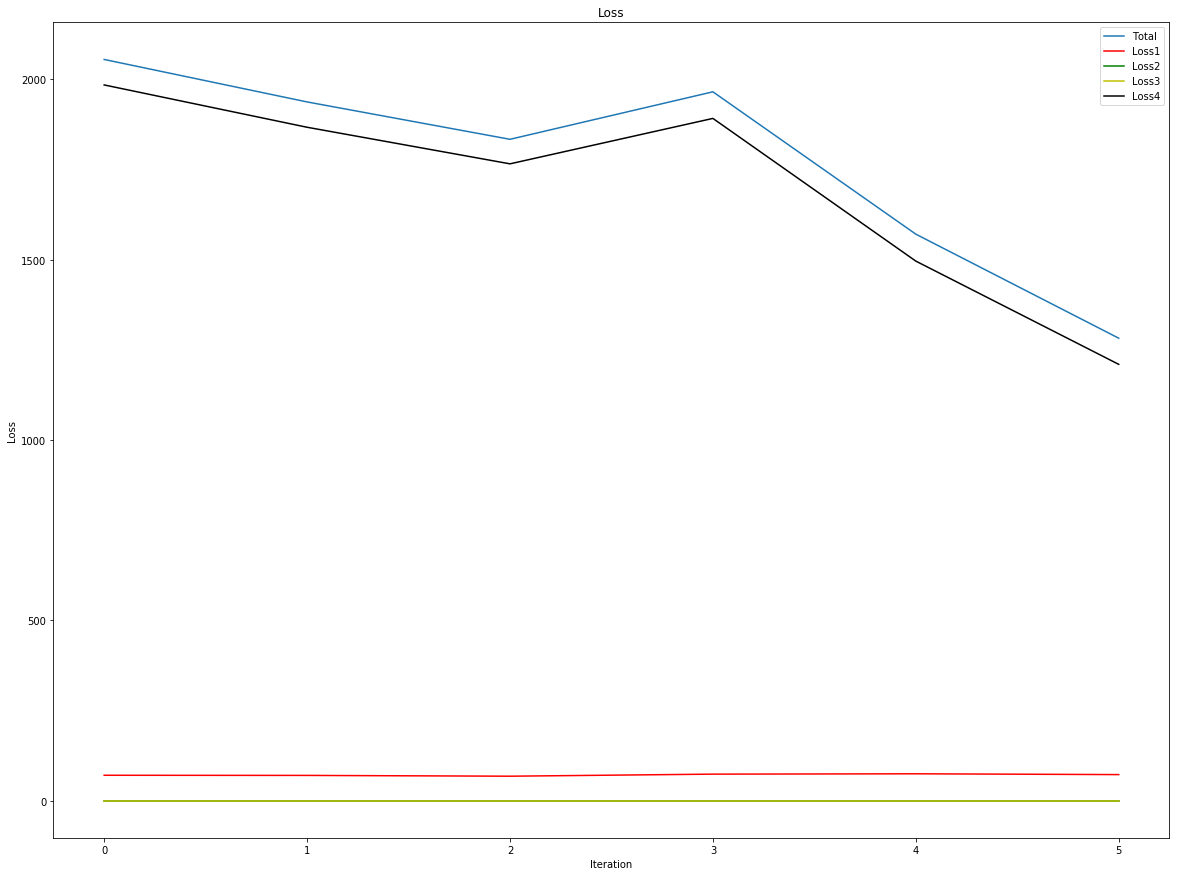

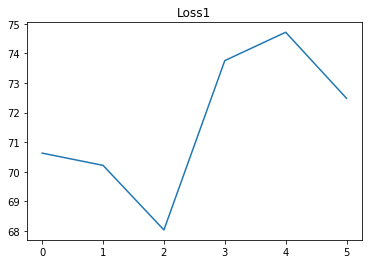

In [3]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt
import torch
from structure_utils import *

dirname = 'test'

losses = []
with open(dirname+'/loss.txt', 'r') as f:
    for iteration in f:
        losses.append([float(term) for term in iteration.split()])
losses = np.array(losses)
# print(losses)
N_iters = losses.shape[0]

# Plot total loss
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(range(N_iters), losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

# Plot loss1 separately
plt.figure()
plt.title('Loss1')
plt.plot(range(N_iters), losses[:, 0])
plt.show()


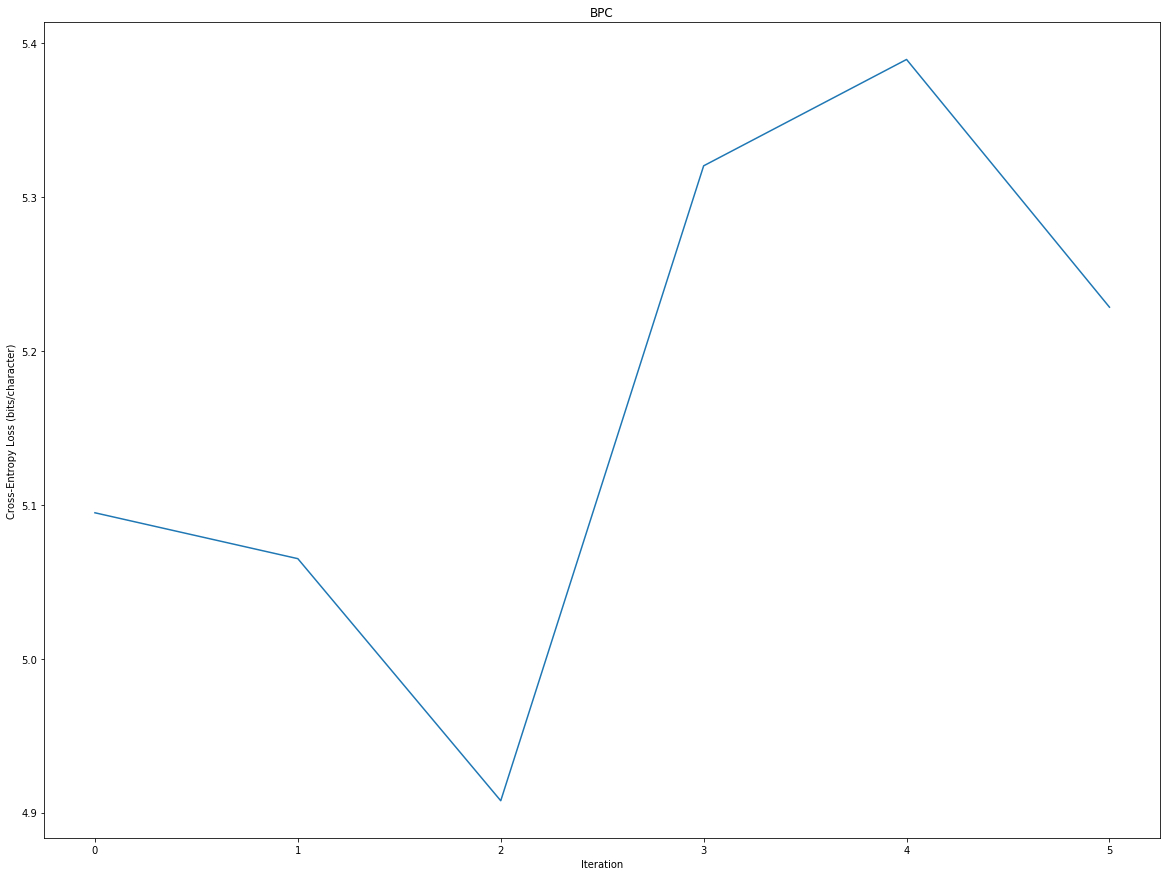

In [4]:
# Plot BPC

bpc = losses[:, 0] / 20 / np.log(2)
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), bpc, label='Total')
plt.title('BPC')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss (bits/character)')
plt.show()

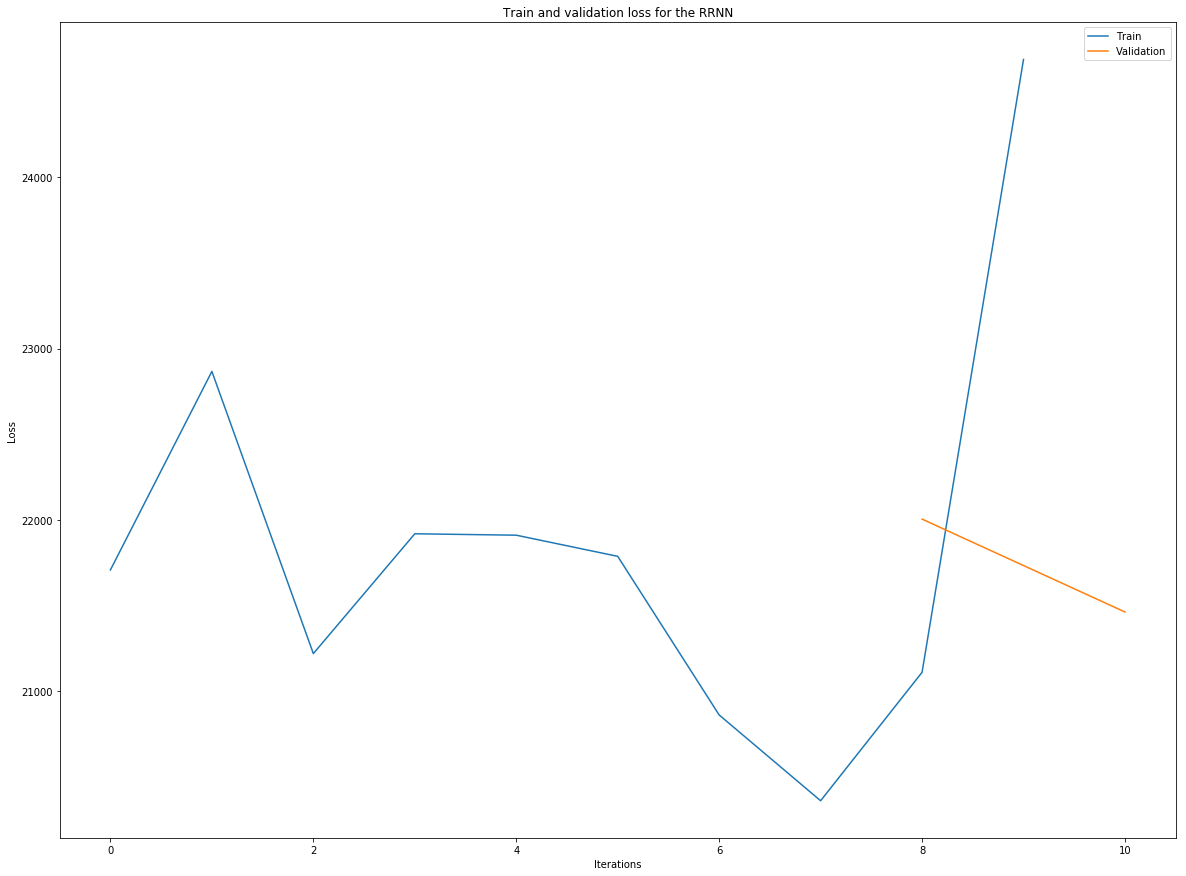

In [3]:
# Plot train and validation loss in the same figure

# Get validation losses
val = []
with open(dirname + '/val_loss.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val = np.array(val)

# Plot
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Train')
valx = val[:, 0]  # The first column of val is the iteration numbers
plt.plot(valx, np.sum(val[:, 1:], axis=1), label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train and validation loss for the RRNN')
plt.show()

# Next do this for an actual GRU model.


/home/matthew/RRNN/env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/matthew/RRNN/env/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


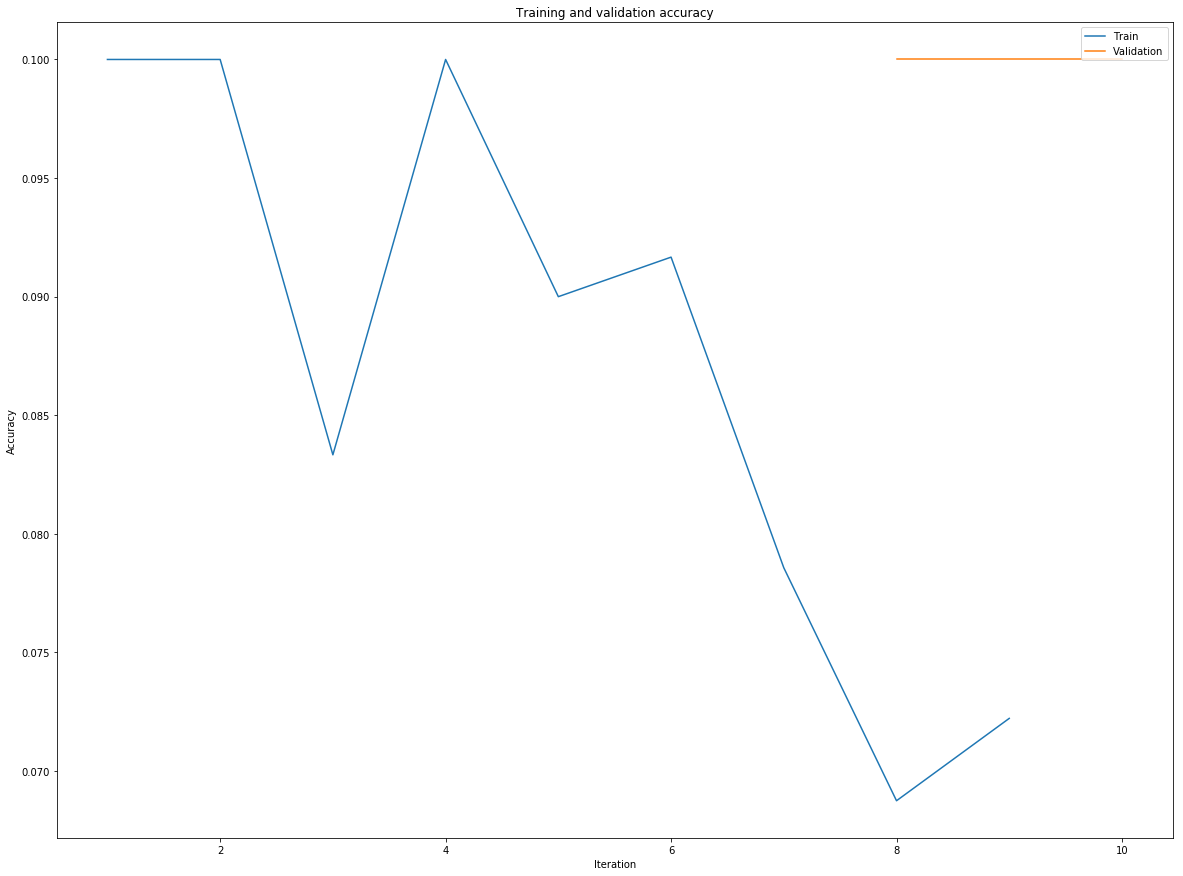

In [4]:
# Training and validation accuracy

val = []
with open(dirname + '/val_acc.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val = np.array(val)

train = []
with open(dirname + '/train_acc.txt', 'r') as f:
    for iteration in f:
        train.append([float(term) for term in iteration.split()])
train = np.array(train)

# Training accuracy here is the average of the last V training examples, 
# where V is the size of the validation set.
val_size = 500
for i in reversed(range(train.shape[0])):
    train[i] = np.mean(train[i-val_size:i])

plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), train, label='Train')
plt.plot(val[:, 0], val[:, 1:], label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(loc='upper right')
plt.show()


In [5]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'batch_size': 1,
 'chunk_length': 20,
 'data_file': 'enwik8_clean.txt',
 'debug': False,
 'embeddings': 'gensim',
 'epochs': 1,
 'epochs_per_checkpoint': 1,
 'lambdas': (20, 1, 0, 2),
 'learning_rate': 1e-05,
 'loss2_margin': 1,
 'multiplier': 0.001,
 'n_processes': 8,
 'nb_train': 10,
 'nb_val': 2,
 'optimizer': 'adam',
 'samples': 1,
 'scoring_hidden_size': None,
 'validate_every': 5,
 'verbose': True}

Runtime: 0:00:17.990344


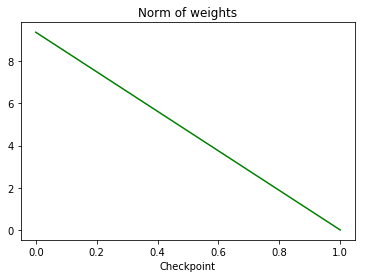

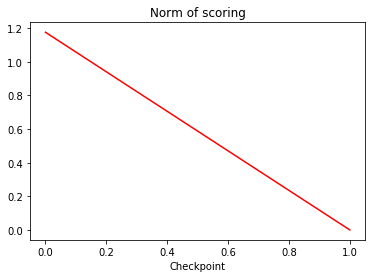

In [7]:
# Display weight magnitudes

epochs = params['epochs']
checkpoints = []
for file in os.listdir(dirname):
    if '.pt' in file:
        checkpoints.append(file)

checkpoints = [torch.load(dirname + '/' + checkpoint) for checkpoint in sorted(checkpoints)]
magnitudes = np.zeros(len(checkpoints))
scoring = np.zeros(len(checkpoints))
        
for weights in checkpoints:
    for weight in weights:
        magnitudes[i] += weights[weight].norm()
        if 'scoring' in weight:
            scoring[i] += weights[weight].norm()
        

plt.figure()
plt.plot(range(len(magnitudes)), magnitudes, 'g')
plt.title('Norm of weights')
plt.xlabel('Checkpoint')
plt.show()

plt.figure()
plt.plot(range(len(scoring)), scoring, 'r')
plt.title('Norm of scoring')
plt.xlabel('Checkpoint')
plt.show()


In [8]:
# Show 5 different structures from training

structures = []
with open(dirname+'/structure.txt') as f:
    lines = f.readlines()
    for line in lines:
        if line != '\n':
            structures.append(line)
            
    spacing = 1000
#     for i in range(0, N_iters, spacing):
# #         print('Iteration', i)
# #         print(structures[i])
#         print()
    
    print('Final structure')
    print(structures[-1])

Final structure
[['x', 'h', 3, 'add', 'identity', 'G0'], ['x', 'G0', 3, 'add', 'identity', 'G1'], ['x', 'G1', 3, 'add', 'identity', 'G2'], ['x', 'G2', 3, 'add', 'identity', 'G3'], ['x', 'G3', 3, 'add', 'identity', 'G4'], ['x', 'G4', 3, 'add', 'identity', 'G5'], ['x', 'G5', 3, 'add', 'identity', 'G6'], ['x', 'G6', 3, 'add', 'identity', 'G7'], ['x', 'G7', 3, 'add', 'identity', 'G8']]



In [9]:
# Show GRU structures
import ast
from tqdm import tqdm

best = None
fewest_differences = np.Inf
best_iter = 0
for i, structure in enumerate(structures):
    structure = ast.literal_eval(structure)
    if structure_is_gru(structure):
        diffs = n_differences(structure, GRU_STRUCTURE)
        if diffs < fewest_differences:
            best = structure
            fewest_differences = diffs
            best_iter = i

            
if best is None:
    print('No GRU structures found.')
else:
    print('Best structure (%d differences from GRU) achieved on iteration %d' % (fewest_differences, best_iter))
    pprint(best)

No GRU structures found.


In [10]:
# Look at spikes

start = int(1e5)
loss4 = losses[:, 3]
spikes = np.argsort(loss4[start:])[::-1] + start
rows = spikes * 2 + 1
for row, spike in zip(rows, spikes):
    print(row-2, loss4[spike-1])
    print(row, loss4[spike])
    print(row+2, loss4[spike+1])
